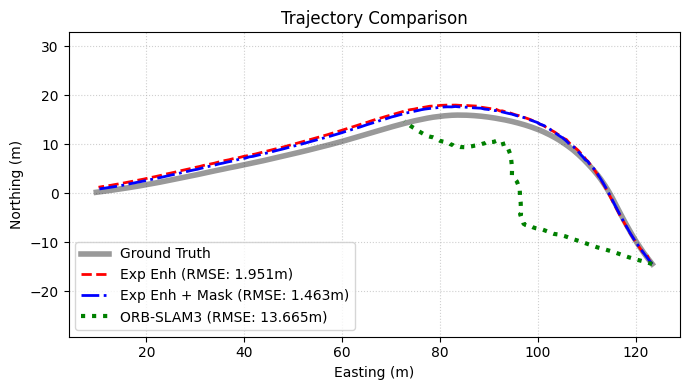

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- Configuration ---
FILE_GT = 'camera_poses.csv'
FILE_METHOD_1 = 'CameraTrajectory.txt'       # Trajectory 1
FILE_METHOD_2 = 'CameraTrajectoryMask.txt'      # Trajectory 2 (Update Name)
FILE_METHOD_3 = 'CameraTrajectoryOrg.txt'      # Trajectory 3 (Update Name)

# ==========================================
#        Helper Functions
# ==========================================

def load_tum(filename):
    """Loads TUM format (timestamp x y z ...)"""
    try:
        df = pd.read_csv(filename, sep=' ', header=None, 
                         names=['t', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw'])
        df['t_sec'] = df['t'] / 1e9  # Convert nanoseconds
        return df
    except FileNotFoundError:
        print(f"Error: Could not find {filename}")
        return None

def load_gt_csv(filename):
    """Loads Ground Truth CSV"""
    df = pd.read_csv(filename)
    df['t_sec'] = df['GPSTime'] / 1e6 # Convert microseconds
    return df

def align_sim3(gt_t, gt_pos, traj_t, traj_pos):
    """
    Aligns a trajectory to Ground Truth and calculates RMSE.
    """
    # 1. Sync: Keep only overlapping points
    valid_idx = (traj_t >= gt_t.min()) & (traj_t <= gt_t.max())
    t_sync = traj_t[valid_idx]
    p_traj_sync = traj_pos[valid_idx]
    
    # Interpolate GT to these specific timestamps
    interp_func = interp1d(gt_t, gt_pos, axis=0, kind='linear')
    p_gt_match = interp_func(t_sync)
    
    # 2. Align (Umeyama Method: Scale + Rotation + Translation)
    mu_g = p_gt_match.mean(0)
    mu_t = p_traj_sync.mean(0)
    g_c = p_gt_match - mu_g
    t_c = p_traj_sync - mu_t
    
    n = len(p_traj_sync)
    C = np.dot(g_c.T, t_c) / n
    U, D, Vt = np.linalg.svd(C)
    S = np.eye(3)
    if np.linalg.det(U) * np.linalg.det(Vt) < 0:
        S[2, 2] = -1
    R = U @ S @ Vt
    
    scale = np.trace(np.diag(D) @ S) / np.sum(t_c**2 / n)
    # t = mu_g - scale * (R @ mu_t)
    t = p_gt_match[0] - scale * (R @ p_traj_sync[0]) # <-- ADD THIS
    
    # Transform
    traj_aligned = (scale * (p_traj_sync @ R.T)) + t
    
    # 3. Calculate RMSE
    errors = np.linalg.norm(p_gt_match - traj_aligned, axis=1)
    rmse = np.sqrt(np.mean(errors**2))
    
    return t_sync, traj_aligned, rmse

# ==========================================
#        Main Execution
# ==========================================

# 1. Load Data
gt_df = load_gt_csv(FILE_GT)
m1_df = load_tum(FILE_METHOD_1)
m2_df = load_tum(FILE_METHOD_2)
m3_df = load_tum(FILE_METHOD_3) # New Load

# Prepare GT Arrays
gt_t = gt_df['t_sec'].values
gt_pos = gt_df[['easting', 'northing', 'altitude']].values

# 2. Process All Methods
# Method 1
t_m1, p_m1_aligned, rmse_m1 = align_sim3(
    gt_t, gt_pos, m1_df['t_sec'].values, m1_df[['x', 'y', 'z']].values
)

# Method 2
t_m2, p_m2_aligned, rmse_m2 = align_sim3(
    gt_t, gt_pos, m2_df['t_sec'].values, m2_df[['x', 'y', 'z']].values
)

# Method 3
t_m3, p_m3_aligned, rmse_m3 = align_sim3(
    gt_t, gt_pos, m3_df['t_sec'].values, m3_df[['x', 'y', 'z']].values
)

# 3. Get "Synced Portion" of Ground Truth
# Find the overall time range covered by ANY of the trajectories
start_time = min(t_m1.min(), t_m2.min(), t_m3.min())
end_time = max(t_m1.max(), t_m2.max(), t_m3.max())

# Slice GT to this exact range
mask_gt = (gt_t >= start_time) & (gt_t <= end_time)
gt_synced_pos = gt_pos[mask_gt]

# ==========================================
#        Plotting
# ==========================================
plt.figure(figsize=(7, 4))

# Plot Synced GT
plt.plot(gt_synced_pos[:, 0], gt_synced_pos[:, 1], 'k-', linewidth=4, alpha=0.4, label='Ground Truth')

# Plot Trajectories
plt.plot(p_m1_aligned[:, 0], p_m1_aligned[:, 1], 'r--', linewidth=2, label=f'Exp Enh (RMSE: {rmse_m1:.3f}m)')
plt.plot(p_m2_aligned[:, 0], p_m2_aligned[:, 1], 'b-.', linewidth=2, label=f'Exp Enh + Mask (RMSE: {rmse_m2:.3f}m)')
plt.plot(p_m3_aligned[:, 0], p_m3_aligned[:, 1], 'g:', linewidth=3, label=f'ORB-SLAM3 (RMSE: {rmse_m3:.3f}m)')

plt.title('Trajectory Comparison')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig('comparison_3_methods.png')
plt.show()

Exp Enh:        Global RMSE=1.9510m, Z-RMSE=0.1544m
Exp Enh + Mask: Global RMSE=1.4629m, Z-RMSE=0.0891m
ORB-SLAM3:      Global RMSE=13.6651m, Z-RMSE=4.3220m


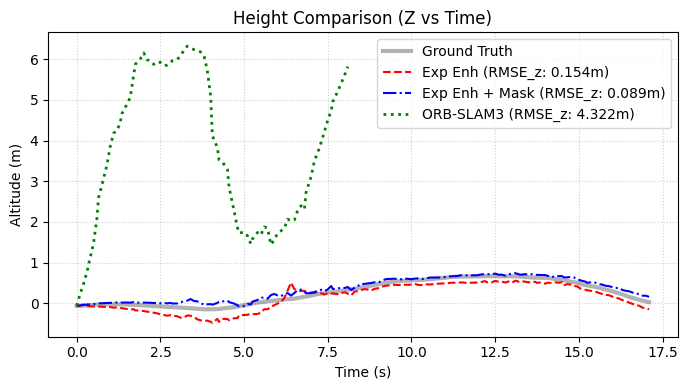

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- Configuration ---
FILE_GT = 'camera_poses.csv'
FILE_METHOD_1 = 'CameraTrajectory.txt'       # Trajectory 1
FILE_METHOD_2 = 'CameraTrajectoryMask.txt'   # Trajectory 2
FILE_METHOD_3 = 'CameraTrajectoryOrg.txt'    # Trajectory 3

# ==========================================
#        Helper Functions
# ==========================================

def load_tum(filename):
    """Loads TUM format (timestamp x y z ...)"""
    try:
        df = pd.read_csv(filename, sep=' ', header=None, 
                         names=['t', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw'])
        df['t_sec'] = df['t'] / 1e9  # Convert nanoseconds
        return df
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

def load_gt_csv(filename):
    """Loads Ground Truth CSV"""
    df = pd.read_csv(filename)
    df['t_sec'] = df['GPSTime'] / 1e6 # Convert microseconds
    return df

def align_sim3(gt_t, gt_pos, traj_t, traj_pos):
    """
    Aligns a trajectory to Ground Truth and calculates RMSE (Global & Z-only).
    Returns: t_sync, traj_aligned, p_gt_match, rmse_global, rmse_z
    """
    # 1. Sync: Keep only overlapping points
    valid_idx = (traj_t >= gt_t.min()) & (traj_t <= gt_t.max())
    t_sync = traj_t[valid_idx]
    p_traj_sync = traj_pos[valid_idx]
    
    # Interpolate GT to these specific timestamps
    interp_func = interp1d(gt_t, gt_pos, axis=0, kind='linear')
    p_gt_match = interp_func(t_sync)
    
    # 2. Align (Umeyama Method: Scale + Rotation + Translation)
    mu_g = p_gt_match.mean(0)
    mu_t = p_traj_sync.mean(0)
    g_c = p_gt_match - mu_g
    t_c = p_traj_sync - mu_t
    
    n = len(p_traj_sync)
    C = np.dot(g_c.T, t_c) / n
    U, D, Vt = np.linalg.svd(C)
    S = np.eye(3)
    if np.linalg.det(U) * np.linalg.det(Vt) < 0:
        S[2, 2] = -1
    R = U @ S @ Vt
    
    scale = np.trace(np.diag(D) @ S) / np.sum(t_c**2 / n)
    
    # Force alignment to start at the same point (Start Anchor)
    t = p_gt_match[0] - scale * (R @ p_traj_sync[0])
    
    # Transform
    traj_aligned = (scale * (p_traj_sync @ R.T)) + t
    
    # 3. Calculate Global RMSE
    errors = np.linalg.norm(p_gt_match - traj_aligned, axis=1)
    rmse_global = np.sqrt(np.mean(errors**2))
    
    # 4. Calculate Z-only RMSE
    # Z is index 2 (x=0, y=1, z=2)
    errors_z = p_gt_match[:, 2] - traj_aligned[:, 2]
    rmse_z = np.sqrt(np.mean(errors_z**2))
    
    return t_sync, traj_aligned, p_gt_match, rmse_global, rmse_z

# ==========================================
#        Main Execution
# ==========================================

# 1. Load Data
gt_df = load_gt_csv(FILE_GT)
m1_df = load_tum(FILE_METHOD_1)
m2_df = load_tum(FILE_METHOD_2)
m3_df = load_tum(FILE_METHOD_3)

# Prepare GT Arrays
gt_t = gt_df['t_sec'].values
gt_pos = gt_df[['easting', 'northing', 'altitude']].values

# 2. Process All Methods
# Note: We now unpack 5 values!
t_m1, p_m1, gt_m1, rmse_m1, rmse_z_m1 = align_sim3(gt_t, gt_pos, m1_df['t_sec'].values, m1_df[['x', 'y', 'z']].values)
t_m2, p_m2, gt_m2, rmse_m2, rmse_z_m2 = align_sim3(gt_t, gt_pos, m2_df['t_sec'].values, m2_df[['x', 'y', 'z']].values)
t_m3, p_m3, gt_m3, rmse_m3, rmse_z_m3 = align_sim3(gt_t, gt_pos, m3_df['t_sec'].values, m3_df[['x', 'y', 'z']].values)

# Print the results
print(f"Exp Enh:        Global RMSE={rmse_m1:.4f}m, Z-RMSE={rmse_z_m1:.4f}m")
print(f"Exp Enh + Mask: Global RMSE={rmse_m2:.4f}m, Z-RMSE={rmse_z_m2:.4f}m")
print(f"ORB-SLAM3:      Global RMSE={rmse_m3:.4f}m, Z-RMSE={rmse_z_m3:.4f}m")

# 3. Get Synced GT Portion (for plotting background)
start_time = min(t_m1.min(), t_m2.min(), t_m3.min())
end_time = max(t_m1.max(), t_m2.max(), t_m3.max())
mask_gt = (gt_t >= start_time) & (gt_t <= end_time)
gt_synced_pos = gt_pos[mask_gt]
gt_synced_t = gt_t[mask_gt]

# ==========================================
#        Plotting
# ==========================================
plt.figure(figsize=(7, 4))

# Normalize time to start at 0
t_start = start_time

# Plot Ground Truth
plt.plot(gt_synced_t - t_start, gt_synced_pos[:, 2], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# --- Configuration ---
FILE_GT = 'camera_poses.csv'
FILE_METHOD_1 = 'CameraTrajectory.txt'
FILE_METHOD_2 = 'CameraTrajectoryMask.txt'
FILE_METHOD_3 = 'CameraTrajectoryOrg.txt'

# ==========================================
#        Helper Functions
# ==========================================

def load_tum(filename):
    """Loads TUM format"""
    try:
        df = pd.read_csv(filename, sep=' ', header=None, 
                         names=['t', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw'])
        df['t_sec'] = df['t'] / 1e9  # Convert nanoseconds
        return df
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

def load_gt_csv(filename):
    """Loads Ground Truth CSV"""
    df = pd.read_csv(filename)
    df['t_sec'] = df['GPSTime'] / 1e6 # Convert microseconds
    return df

def align_sim3(gt_t, gt_pos, traj_t, traj_pos):
    """
    Aligns trajectory to GT (Start Anchor) and returns matched points
    """
    # 1. Sync
    valid_idx = (traj_t >= gt_t.min()) & (traj_t <= gt_t.max())
    t_sync = traj_t[valid_idx]
    p_traj_sync = traj_pos[valid_idx]
    
    interp_func = interp1d(gt_t, gt_pos, axis=0, kind='linear')
    p_gt_match = interp_func(t_sync)
    
    # 2. Align (Umeyama)
    mu_g = p_gt_match.mean(0)
    mu_t = p_traj_sync.mean(0)
    g_c = p_gt_match - mu_g
    t_c = p_traj_sync - mu_t
    
    n = len(p_traj_sync)
    C = np.dot(g_c.T, t_c) / n
    U, D, Vt = np.linalg.svd(C)
    S = np.eye(3)
    if np.linalg.det(U) * np.linalg.det(Vt) < 0:
        S[2, 2] = -1
    R = U @ S @ Vt
    scale = np.trace(np.diag(D) @ S) / np.sum(t_c**2 / n)
    
    # Start Anchor (Force start to match)
    t = p_gt_match[0] - scale * (R @ p_traj_sync[0])
    
    # Transform
    traj_aligned = (scale * (p_traj_sync @ R.T)) + t
    
    return p_gt_match, traj_aligned

# ==========================================
#        Main Execution
# ==========================================

# 1. Load Data
gt_df = load_gt_csv(FILE_GT)
m1_df = load_tum(FILE_METHOD_1)
m2_df = load_tum(FILE_METHOD_2)
m3_df = load_tum(FILE_METHOD_3)

gt_t = gt_df['t_sec'].values
gt_pos = gt_df[['easting', 'northing', 'altitude']].values

# 2. Print Header
print(f"{'Method':<20} | {'RMSE Mean':<10} | {'RMSE X':<10} | {'RMSE Y':<10} | {'RMSE Z':<10}")
print("-" * 75)

# 3. Process & Print
methods = [
    ('Exp Enh', m1_df),
    ('Exp Enh + Mask', m2_df),
    ('ORB-SLAM3', m3_df)
]

for name, df in methods:
    if df is not None:
        # Align
        p_gt, p_est = align_sim3(gt_t, gt_pos, df['t_sec'].values, df[['x', 'y', 'z']].values)
        
        # Calculate Difference
        diff = p_gt - p_est
        
        # Calculate RMSE per axis
        rmse_x = np.sqrt(np.mean(diff[:, 0]**2))
        rmse_y = np.sqrt(np.mean(diff[:, 1]**2))
        rmse_z = np.sqrt(np.mean(diff[:, 2]**2))
        
        # Calculate Global RMSE (Euclidean distance mean)
        rmse_mean = np.sqrt(np.mean(np.linalg.norm(diff, axis=1)**2))
        
        print(f"{name:<20} | {rmse_mean:<10.4f} | {rmse_x:<10.4f} | {rmse_y:<10.4f} | {rmse_z:<10.4f}")
plt.tight_layout()
plt.savefig('height_comparison_z_rmse.png')
plt.show()

In [11]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# --- Configuration ---
FILE_GT = 'camera_poses.csv'
FILE_METHOD_1 = 'CameraTrajectory.txt'
FILE_METHOD_2 = 'CameraTrajectoryMask.txt'
FILE_METHOD_3 = 'CameraTrajectoryOrg.txt'

# ==========================================
#        Helper Functions
# ==========================================

def load_tum(filename):
    """Loads TUM format"""
    try:
        df = pd.read_csv(filename, sep=' ', header=None, 
                         names=['t', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw'])
        df['t_sec'] = df['t'] / 1e9  # Convert nanoseconds
        return df
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

def load_gt_csv(filename):
    """Loads Ground Truth CSV"""
    df = pd.read_csv(filename)
    df['t_sec'] = df['GPSTime'] / 1e6 # Convert microseconds
    return df

def align_sim3(gt_t, gt_pos, traj_t, traj_pos):
    """
    Aligns trajectory to GT (Start Anchor) and returns matched points
    """
    # 1. Sync
    valid_idx = (traj_t >= gt_t.min()) & (traj_t <= gt_t.max())
    t_sync = traj_t[valid_idx]
    p_traj_sync = traj_pos[valid_idx]
    
    interp_func = interp1d(gt_t, gt_pos, axis=0, kind='linear')
    p_gt_match = interp_func(t_sync)
    
    # 2. Align (Umeyama)
    mu_g = p_gt_match.mean(0)
    mu_t = p_traj_sync.mean(0)
    g_c = p_gt_match - mu_g
    t_c = p_traj_sync - mu_t
    
    n = len(p_traj_sync)
    C = np.dot(g_c.T, t_c) / n
    U, D, Vt = np.linalg.svd(C)
    S = np.eye(3)
    if np.linalg.det(U) * np.linalg.det(Vt) < 0:
        S[2, 2] = -1
    R = U @ S @ Vt
    scale = np.trace(np.diag(D) @ S) / np.sum(t_c**2 / n)
    
    # Start Anchor (Force start to match)
    t = p_gt_match[0] - scale * (R @ p_traj_sync[0])
    
    # Transform
    traj_aligned = (scale * (p_traj_sync @ R.T)) + t
    
    return p_gt_match, traj_aligned

# ==========================================
#        Main Execution
# ==========================================

# 1. Load Data
gt_df = load_gt_csv(FILE_GT)
m1_df = load_tum(FILE_METHOD_1)
m2_df = load_tum(FILE_METHOD_2)
m3_df = load_tum(FILE_METHOD_3)

gt_t = gt_df['t_sec'].values
gt_pos = gt_df[['easting', 'northing', 'altitude']].values

# 2. Print Header
print(f"{'Method':<20} | {'RMSE Mean':<10} | {'RMSE X':<10} | {'RMSE Y':<10} | {'RMSE Z':<10}")
print("-" * 75)

# 3. Process & Print
methods = [
    ('Exp Enh', m1_df),
    ('Exp Enh + Mask', m2_df),
    ('ORB-SLAM3', m3_df)
]

for name, df in methods:
    if df is not None:
        # Align
        p_gt, p_est = align_sim3(gt_t, gt_pos, df['t_sec'].values, df[['x', 'y', 'z']].values)
        
        # Calculate Difference
        diff = p_gt - p_est
        
        # Calculate RMSE per axis
        rmse_x = np.sqrt(np.mean(diff[:, 0]**2))
        rmse_y = np.sqrt(np.mean(diff[:, 1]**2))
        rmse_z = np.sqrt(np.mean(diff[:, 2]**2))
        
        # Calculate Global RMSE (Euclidean distance mean)
        rmse_mean = np.sqrt(np.mean(np.linalg.norm(diff, axis=1)**2))
        
        print(f"{name:<20} | {rmse_mean:<10.4f} | {rmse_x:<10.4f} | {rmse_y:<10.4f} | {rmse_z:<10.4f}")

Method               | RMSE Mean  | RMSE X     | RMSE Y     | RMSE Z    
---------------------------------------------------------------------------
Exp Enh              | 1.9510     | 1.1256     | 1.5860     | 0.1544    
Exp Enh + Mask       | 1.4629     | 0.7045     | 1.2790     | 0.0891    
ORB-SLAM3            | 13.6651    | 12.4805    | 3.5062     | 4.3220    
